# Redes Neuronales para clasificación de imagenes.



In [1]:
# Se importan bibliotecas
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

<a name='2'></a>
## 1 - Cargando y preprocesando el dataset

El dataset esta compuesto de imagenes de gatos y no gatos (diversos animales y objetos). 

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

La siguiente celda permite ver una imagen del dataset, puedes cambiar la variable *index* para ver otra imagen.

y = 1. It's a cat picture.


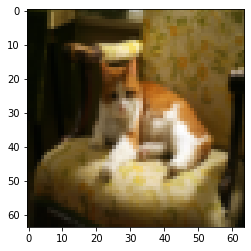

In [3]:
# Ejemplo de imagen en el dataset
index = 7
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explorando el dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Para este tipo de red neuronal (densa), es común convertir la imagen en un vector que alimenta la red neuronal.

<img src="https://images-mlproduction.s3.amazonaws.com/imvectorkiank.png" style="width:650px;height:400px;">

In [5]:
# Creando los vectores de datos.
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Convirtiendo las imagenes de la escala 0-255 a 0-1
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


**Note**:
$12,288$ equals $64 \times 64 \times 3$, which is the size of one reshaped image vector.

<a name='3'></a>
## 2 - Arquitectura del modelo

<a name='3-1'></a>
### Red neuronal de 2 capas.

Una vez que hemos manipulado el dataset, es momento de contruir el modelo neuronal que permita distinguir entre imagenes de gatos de las que no lo son. 

La arquitectura de este modelo es de la siguiente forma.

<img src="https://images-mlproduction.s3.amazonaws.com/2layerNN_kiank.png" style="width:650px;height:400px;">

<a name='3-2'></a>
### 3 Red neuronal de L capas.

Dependiendo del número de capas, la representación de la red puede ser complicada. Una representación simplificada es:

<img src="https://images-mlproduction.s3.amazonaws.com/LlayerNN_kiank.png" style="width:650px;height:400px;">



In [6]:
# Hiperparámetros del modelo.

n_x = 12288     # Vector de entrafas: num_px * num_px * 3 
n_h = 7         # Neuronas en la capa oculta 
n_y = 1         # Neuronas en la capa de salida
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [7]:
# Calculo del gradiente

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')

        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()


# Entrenando el modelo 

Entrenar un red neuronal, no es otra cosa que ejecutar el algoritmo de retropropagación, en búsqueda de minimizar la función de costo (error). De forma general, si la función de costo decrece es un indicio de que el entrenamiento va por buen camino (aunque hay que evitar caer en el sobreajuste  u *overfitting*)

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203889
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.30527536361962637
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.24681768210614818
Cost after iteration 1400: 0.1985073503746612
Cost after iteration 1500: 0.17448318112556635
Cost after iteration 1600: 0.1708076297809699
Cost after iteration 1700: 0.11306524562164708
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726871
Cost after iteration 2000: 0.07439078704319087
Cost after iteration 2100: 0.0663074813

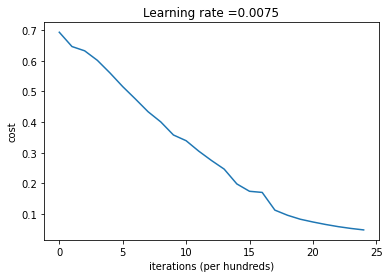

In [8]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [9]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [10]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


#### Podemos observar que en el conjunto de entrenamiento, se tiene una exactitud del 99% y en el conjunto de prueba tenemos un 72%.Esto nos habla de un sobreajuste. 





## Red neuronal de L capas

In [11]:
# Red de 4 capas
# 20 neuronas en la primer capa oculta
# 7 neuronas en la segunda capa oculta
# 5 neuronas en la tercer capa oculta
# 1 neurona en la ćapa de salida
layers_dims = [12288, 20, 7, 5, 1] # 

In [12]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

# Entrenando el modelo 

Entrenar un red neuronal, no es otra cosa que ejecutar el algoritmo de retropropagación, en búsqueda de minimizar la función de costo (error). De forma general, si la función de costo decrece es un indicio de que el entrenamiento va por buen camino (aunque hay que evitar caer en el sobreajuste  u *overfitting*)

In [13]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.36912585249592794
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005212
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.1078392

In [14]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [15]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


#### Podemos observar que en el conjunto de entrenamiento, se tiene una exactitud del 98% y en el conjunto de prueba tenemos un 80%.Esto nos habla de un sobreajuste. 

##  Análisis de resultados

Veamos casos en los que la red neuronal se equivoca.


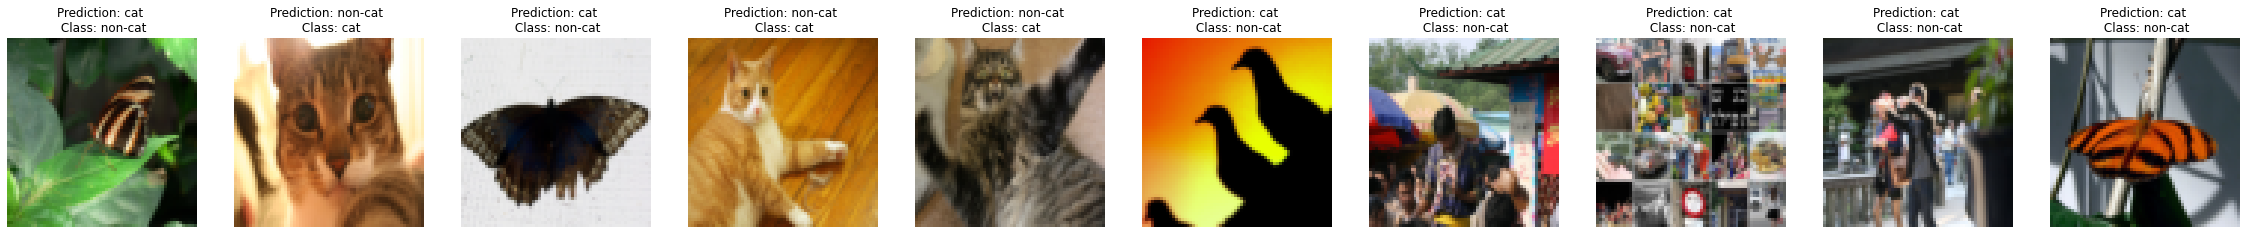

In [16]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**En estos casos podemos observar: **
- El cuerpo del gato esta en una posición inusual. 
- El fondo y el color del gato se confunde.
- Especie de dato inisual.
- Ángulo de la cámara.
- Brillo de la imagen.
- Variaciones en la escala. 

## Probando el modelo con imagenes propias. 

In [17]:
my_image = "obama.jpeg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

plt.figure(figsize=(6, 3))
fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

FileNotFoundError: ignored

<Figure size 432x216 with 0 Axes>